## Capstone Project 2: Clustering and Modeling Op-Ed Articles from the New York Times

### Data cleaning/importing / processing / language parsing



In [248]:
import pandas as pd
import numpy as np
import json
from readability.readability import Document
import urllib.request
import requests
import time
import itertools
import spacy
import re
import string
from nytimesarticle import articleAPI
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
%matplotlib inline


In [249]:
#use the nytimes api to get articles by opinion writers
key = "10c5e2b9f97644c7bead47a4ba1f1b55"
api = articleAPI(key)


In [250]:
# create list of opinion writers at nytimes
writers = ['Charles M. Blow','David Brooks','Frank Bruni','Roger Cohen','Gail Collins',
          'Ross Douthat','Maureen Dowd','Thomas L. Friedman','Michelle Goldberg','Nicholas Kristof',
          'Paul Krugman','David Leonhardt','Andrew Rosenthal','Bret Stephens']
writers = [x.upper() for x in writers]
print(writers)

['CHARLES M. BLOW', 'DAVID BROOKS', 'FRANK BRUNI', 'ROGER COHEN', 'GAIL COLLINS', 'ROSS DOUTHAT', 'MAUREEN DOWD', 'THOMAS L. FRIEDMAN', 'MICHELLE GOLDBERG', 'NICHOLAS KRISTOF', 'PAUL KRUGMAN', 'DAVID LEONHARDT', 'ANDREW ROSENTHAL', 'BRET STEPHENS']


In [251]:
# function from http://dlab.berkeley.edu/blog/scraping-new-york-times-articles-python-tutorial that breaks the output from 
# the nytimes api into a list of dictionaries (per article)

def parse_articles(articles):
    '''
    This function takes in a response to the NYT api and parses
    the articles into a list of dictionaries
    '''
    news = []
    for i in articles['response']['docs']:
        dic = {}
        dic['headline'] = i['headline']['main'].encode("utf8")
        dic['date'] = i['pub_date'][0:10] # cutting time of day.
        #dic['source'] = i['source']
        dic['byline'] = i['byline']
        dic['type_material'] = i['type_of_material']
        dic['url'] = i['web_url']
        dic['word_count'] = i['word_count']
      #  dic['persons'] = i['persons']
        # locations
        locations = []
        # subject
        subjects = []
        for x in range(0,len(i['keywords'])):
            if 'subject' in i['keywords'][x]['name']:
                subjects.append(i['keywords'][x]['value'])
        dic['subjects'] = subjects   
        news.append(dic)
    return(news) 

In [308]:
# create dataframe for articles: Collect urls to article for each opinion writer
# ran three times: page1, page2 and page3
df = pd.DataFrame(columns=['byline','date','headline','source','subjects','type_material','url','word_count'])
for writer in writers:
    df_temp = pd.DataFrame()
    print(writer)
    ar = requests.get("http://api.nytimes.com/svc/search/v2/articlesearch.json?q="+"{}".format(writer)+"&page=3&begin_date=20160101&do&api-key=10c5e2b9f97644c7bead47a4ba1f1b55")
    data = ar.json()
    articles_list = parse_articles(data)
    df_temp = pd.DataFrame(articles_list)
    df = pd.concat([df,df_temp])
    time.sleep(1)
#len(data["response"]["docs"])

In [309]:
# create a csv of the url list
df.shape
df.to_csv('ny_times_url_dataframep3.csv', index=False,encoding = 'utf-8')
#print(df.head())

#### Data Processing in Excel
I combined the output from the 3 different queries into a single csv directly in Excel. I also removed records that did not include a url or were not Op-Ed pieces

In [287]:
# loading the processed csv containing the urls for all of the op-ed pieces
df_urls = pd.read_csv('ny_times_url_dataframe.csv', encoding = 'utf-8')
df_urls.shape


(307, 8)

In [174]:
#use beautiful soup to scrape the full text articles at the urls loaded from the csv
full_text = []
url_values = df_urls['url'].tolist()
#print(len(url_values))

session = requests.Session()
for item in url_values:
    #time.sleep(1)
#     url_value = item
#     print(url_value)
    req = session.get(item)
    soup = BeautifulSoup(req.text,'html.parser')
    p_tags = soup.find_all(class_="story-body-text story-content")
    #print(p_tags)
# method 1
    article = ''
    for p_tag in p_tags:
        p_text = p_tag.get_text()
        #print(p_text)
        article += p_text
    full_text.append(article)



In [310]:
# created a dataframe with the text for each article and then combined the output with the metadata into a second dataframe 
df1 = pd.DataFrame({'full_text': full_text})
combined_df = pd.concat([df_urls, df1], axis=1, join_axes=[df_urls.index])

# dropped url, headline, type_material (all Op_Ed) from the dataset
data = combined_df.drop(['source','type_material','headline','url'],axis=1)

In [334]:
#save the data df to json
data.to_json('nytimes_oped_articles.json')

In [43]:
#import json back into jupyter 
op_ed_articles = pd.read_json('nytimes_oped_articles.json')
#print(op_ed_articles['full_text'][2])
op_ed_articles = op_ed_articles.reset_index(drop=True)
op_ed_articles.head()

,byline,date,full_text,subjects,word_count
0,ANDREW ROSENTHAL,2017-10-19,When most Americans think of domestic terroris...,"['Blacks', 'Police Brutality, Misconduct and S...",753
1,ANDREW ROSENTHAL,2017-10-04,It’s time to talk about taking away guns — not...,"['Gun Control', 'Firearms', 'Las Vegas, Nev, S...",776
2,ANDREW ROSENTHAL,2017-05-18,"In normal times, the appointment of a former F...",['Special Prosecutors (Independent Counsel)'],686
3,DAVID LEONHARDT,2017-11-29,This article is part of the Opinion Today news...,"['United States Politics and Government', 'Tax...",528
4,DAVID LEONHARDT,2017-11-02,This article is part of the Opinion Today news...,"['Taxation', 'Baseball', 'Officiating (Sports)...",725


In [253]:
# Utility function for standard text cleaning.
def text_cleaner(text):    
     # Visual inspection identifies a form of punctuation spaCy does not
    # remove parentheses
    text = re.sub("[\(|\)]", "", text)
    # remove non-ascii characters
    text = re.sub(r'[^\x00-\x7F]','', text)
    # remove single character words
    #text = re.sub(r"\b[a-zA-Z]\b", "", text)
    # remove double hyphen
    text = re.sub(r'--','-',text)
    # regular expression that replaces brackets and anything between them with nothing
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    

In [255]:
# clean up the text 
for index, row in op_ed_articles.iterrows():
        i = row['full_text'].lower()
        i = text_cleaner(i)
        op_ed_articles.loc[index, "full_text"] = i
        

In [259]:
# create train/test dataset for full texts
y = op_ed_articles['byline']
X = op_ed_articles.drop(['byline','subjects'],axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25)



In [46]:
# tokenize the text
nlp = spacy.load('en')
op_ed_articles['full_text_tokenized'] = op_ed_articles['full_text'].apply(lambda x: nlp(x))


In [327]:
op_ed_articles.head()
op_ed_articles.to_csv('for_paper.csv')

In [264]:
op_ed_articles.shape


(307, 6)

In [50]:
# Create a new DataFrame with an entry per sentence for the training set
combine_Xtrain_ytrain = pd.concat([X,y],axis=1)
combine_Xtrain_ytrain = combine_Xtrain_ytrain.drop(['date','subjects','word_count','full_text'],axis=1)
combine_Xtrain_ytrain.head()

,full_text_tokenized,byline
0,"(when, most, americans, think, of, domestic, t...",ANDREW ROSENTHAL
1,"(its, time, to, talk, about, taking, away, gun...",ANDREW ROSENTHAL
2,"(in, normal, times, ,, the, appointment, of, a...",ANDREW ROSENTHAL
3,"(this, article, is, part, of, the, opinion, to...",DAVID LEONHARDT
4,"(this, article, is, part, of, the, opinion, to...",DAVID LEONHARDT


In [290]:
# create a dataframe of sentences for bag of words
opinions_sentences_training_set = pd.DataFrame(columns=['full_text_sentences','author'])
for writer in writers:
    for index, row in combine_Xtrain_ytrain.iterrows():
        if row['byline'] == writer:
            df_temp = pd.DataFrame()
            sentences = []
            author = writer
            sentences = [sent for sent in row['full_text_tokenized'].sents]
            df_temp = pd.DataFrame({'full_text_sentences': sentences,'author': author})
            opinions_sentences_training_set = pd.concat([opinions_sentences_training_set,df_temp])
opinions_sentences_training_set = opinions_sentences_training_set.reset_index(drop=True)
#opinions_sentences_training_set.head(n=122)


In [325]:
# create a merged text for each writer
# Create a new DataFrame with an entry per sentence for the training set
combine_Xtext_train_ytrain = pd.concat([X,y],axis=1)
combine_Xtext_train_ytrain = combine_Xtext_train_ytrain.drop(['date','subjects','word_count','full_text_tokenized'],axis=1)
combine_Xtext_train_ytrain= combine_Xtext_train_ytrain.sort_values(['byline'])
# print(combine_Xtext_train_ytrain)


df_writer_combined_text = pd.DataFrame()

for writer in writers:
    writer_text = ''
    writer_text_list = []
    n=0
    for index, row in combine_Xtext_train_ytrain.iterrows():
        if row['byline'] == writer:
            author = writer
            writer_text_list.append(row['full_text'])
    writer_text = " ".join(writer_text_list)
    df_temp = pd.DataFrame({'combined_text': writer_text,'author': author},index=[n])
    df_writer_combined_text = pd.concat([df_writer_combined_text,df_temp])
    n += 1
df_writer_combined_text = df_writer_combined_text.reset_index(drop=True)
#df_writer_combined_text.head(n=20)            

In [17]:
# tokenize the text

df_writer_combined_text['combined_text_tokenized'] = df_writer_combined_text['combined_text'].apply(lambda x: nlp(x))


## Feature Engineering 
- creating an initial set of features to use for clustering and modeling

### Bag of Words:

In [332]:
# Utility function to create a list of the 1000 most common words. 

def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(1000)]

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, words_in_articles):
    
    # Scaffold the data frame (training data/target dataset) and initialize counts to zero.
    df = pd.DataFrame(columns=words_in_articles)
    df['text_sentence'] = opinions_sentences_training_set['full_text_sentences']
    df['text_source'] = opinions_sentences_training_set['author']
    df.loc[:, words_in_articles] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    
    for i, sentence in enumerate(df['text_sentence']):
        
         # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     token.lemma_ in words_in_articles
                     and not token.is_punct
                     and not token.is_stop
    
                 )]
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
 
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df




In [333]:
# return most common words for writers

common_words = []
for i, row in df_writer_combined_text.iterrows():
    baggedwords = bag_of_words(row['combined_text_tokenized'])
    common_words.append(baggedwords)

flat_list=[]
for sublist in common_words:
    for item in sublist:
        flat_list.append(item)
        

words_in_articles = set(flat_list)
# print(words_in_articles)
# print(len(words_in_articles))

In [334]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, words_in_articles)
word_counts.shape


Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500


(8862, 4463)

In [335]:
word_counts.head()

,thanksgiving,80,purdue,driver,pin,proportion,rod,impact,history,incompetence,...,granted.the,loophole,warrior,bndchen,weapon,regional,class,wind,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(steve, bannon, may, no, longer, be, physicall...",CHARLES M. BLOW
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(leadership, ,, breitbart, has, given, favorab...",CHARLES M. BLOW
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(and, spencer, loves, it.yes, ,, that, richard...",CHARLES M. BLOW
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(that, was, the, same, protest, about, which, ...",CHARLES M. BLOW
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,"(i, do, nt, think, it, has, done, this, delibe...",CHARLES M. BLOW


In [378]:
# create features with tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer

ft_list=[]
for i,row in op_ed_articles.iterrows():
    article=row['full_text']
    ft_list.append(article)
#print(ft_list)

vectorizer = TfidfVectorizer(max_df=0.6, # drop words that occur in more than half the articles
                             stop_words='english', 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
#Applying the vectorizer
full_text_tfidf=vectorizer.fit_transform(ft_list)
print("Number of features: %d" % full_text_tfidf.get_shape()[1])


# #Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = full_text_tfidf.tocsr()

# #number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per article
tfidf_byarticle = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each article, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_byarticle[i][terms[j]] = X_train_tfidf_csr[i, j]
    
 #Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
#print('Original sentence:', op_ed_articles['full_text'][2])
#print('Tf_idf vector:', tfidf_byarticle[2])

Number of features: 20140


In [379]:
# Latent Semantic Analysis (apply PCA to tf-idf output)

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1081 to 100.
svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(full_text_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)
print(X_train_lsa.shape)

Percent variance captured by all components: 100.0
(307, 307)


In [380]:
# for BoW dataset
Y = op_ed_articles['byline']
#X = np.array(word_counts.drop(['text_sentence','text_source'],axis=1))
X = X_train_lsa
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X, 
                                                    Y,stratify=Y,
                                                    test_size=0.25,
                                                    random_state=0)

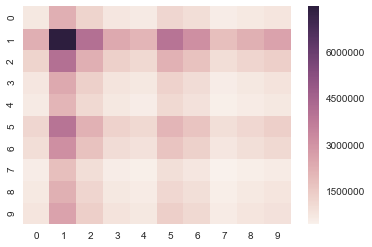

In [381]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_tfidf) * np.asmatrix(X_train_tfidf).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

# #Generating a key for the plot.
# print('Key:')
# for i in range(20):
#     print(i,sim_matrix.index[i])


In [382]:
# reduce number of words in bow

#Our SVD data reducer.  We are going to reduce the feature space from 1081 to 100.
svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X = np.array(word_counts.drop(['text_sentence','text_source'],axis=1))
X_train_lsa_bow = lsa.fit_transform(X)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 82.004393954


### Clustering 
- Trying Kmeans, Mean-Shift and Spectral Clustering approaches to clustering
- There are 14 Op-Ed writers for the New York Times included in this analysis so that is the number of clusters I'd ideally identify




col_0               0   1   2   3   4   5   6   7   8   9   10  11  12  13
byline                                                                    
ANDREW ROSENTHAL     0   0   0   1   0   1   6   0   1   0   0   0   3   0
BRET STEPHENS        0   1   0   0   4   0   1   1   0   2   0   0   9   4
CHARLES M. BLOW      0   5   0   0   0   0   9   4   0   0   0   0   3   0
DAVID BROOKS         2   2   0   3   0   0   0   0   1   0   1   2   2   1
DAVID LEONHARDT      0   0   3   3   0   0   3   6  11   0   0   1   0   1
FRANK BRUNI          0   3   1   3   0   0   3   1   0   0   0   0   5   3
GAIL COLLINS         0   0   3   1   0   1   1   2   2   0   0   1   2   1
MAUREEN DOWD         0   1   1   0   0   1   3   1   0   0   0   3   1   0
MICHELLE GOLDBERG    0   0   2   2   0   0   1   0   0   0   1   0   1   2
NICHOLAS KRISTOF     0   0   3   0   3   3   0   1   0   0   2   0   2   0
PAUL KRUGMAN         0   0   1   0   0   0   0   0   6   0   0   0   3   0
ROGER COHEN          0   

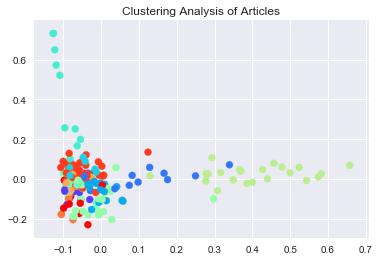

In [383]:
# clustering using k-means and tf-idf generated data
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

X = X_train_lsa
Y = combine_Xtrain_ytrain['byline']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,stratify=Y,
                                                    test_size=0.25,
                                                    random_state=0)
X_pca = PCA(2).fit_transform(X_train)

# Get predicted clusters.
y_pred = KMeans(n_clusters=14, random_state=42).fit_predict(X_train)
crosstab_kmeans = pd.crosstab(y_train, y_pred) 
print(crosstab_kmeans)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred,cmap=cm.rainbow)
plt.title('Clustering Analysis of Articles')
plt.show()



col_0                0   1   2   3   4   5   6    7   8   9   10  11  12  13
author                                                                      
ANDREW ROSENTHAL     65   2   5  10   3   0  27    3   8   7  14  11   1  41
BRET STEPHENS       388  16  20  25  44   2  25    1  18  41  21  26  24  35
CHARLES M. BLOW     235  17   7  40   9   1  23    2   8  28  25  13  14  89
DAVID BROOKS        261  25   7  26   3   1  19   12  19  19   2  19  23  17
DAVID LEONHARDT     252  45   4  19  16  24  21  127  14  28  25  44  17  28
FRANK BRUNI         299  21  44  27  11   0  34    2  13  47  30  20  15  56
GAIL COLLINS        178  17  20  27  23   4  23   23  27  19  18  16  14  26
MAUREEN DOWD        156   9  13   7   5   1  27    2  13  13  27  15   7  49
MICHELLE GOLDBERG   107  15   6   9  10   0  18    8  13  23  17   8   7  40
NICHOLAS KRISTOF    174   2  13  24  17  48  32    4  15  21   7   8   9   6
PAUL KRUGMAN         65  16   8  10   1   0   3   55  13  13   4   6   1  13

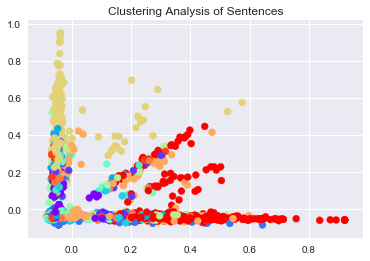

In [384]:
# clustering using kmeans and bow data
X = X_train_lsa_bow

Y = opinions_sentences_training_set['author']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,stratify=Y,
                                                    test_size=0.25,
                                                    random_state=0)
X_pca = PCA(2).fit_transform(X_train)

# Get predicted clusters.
y_pred = KMeans(n_clusters=14, random_state=42).fit_predict(X_train)
crosstab_kmeans = pd.crosstab(y_train, y_pred) 
print(crosstab_kmeans)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred,cmap=cm.rainbow)
plt.title('Clustering Analysis of Sentences')
plt.show()



Number of estimated clusters: 1


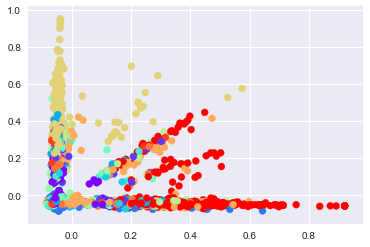

In [385]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X_train, quantile=0.2)

# Declare and fit the model.
#ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms = MeanShift(bin_seeding=True)
ms_fit = ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred,cmap=cm.rainbow)
plt.show()


Comparing the assigned categories to the ones in the data:
col_0               0    1   2   3   4   5   6    7   8   9   10  11  12  13
author                                                                      
ANDREW ROSENTHAL    13   79  20   3  11   1  13    2   0   2   6  32   6   9
BRET STEPHENS       30  446  12  13  25   3  20    0   0  23  39  25  25  25
CHARLES M. BLOW     19  270  18   6  42   1  23    1   0  15  18  76  11  11
DAVID BROOKS        20  299   5   5  24   1   2   12   0   6  19  14  27  19
DAVID LEONHARDT     14  318  11   3  22   2  25  121  24  13  21  26  21  43
FRANK BRUNI         24  351  18  33  27   0  31    2   0  10  42  53  13  15
GAIL COLLINS         7  212  23  13  29   2  23   27   0   9  17  24  31  18
MAUREEN DOWD         1  184  32   8   9   0  27    2   0   6  11  36  12  16
MICHELLE GOLDBERG   14  139  10   7  10   0  15    8   0   4  20  36  11   7
NICHOLAS KRISTOF    31  231  16  10  25  10   7    4   0   2  10   5  19  10
PAUL KRUGMAN     

C:\Users\stace\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


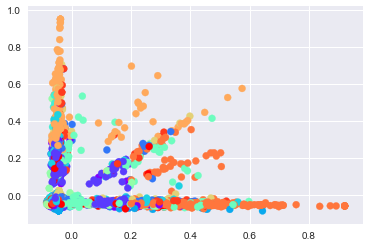

In [386]:
from sklearn.cluster import SpectralClustering

n_clusters=14

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict,cmap=cm.rainbow)
plt.legend(loc="lower right")
plt.show()


### Try predictive modeling with bag of words features

In [243]:
# reduce number of words in bow

#Our SVD data reducer.  We are going to reduce the feature space from 1081 to 100.
svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X = np.array(word_counts.drop(['text_sentence','text_source'],axis=1))
X_train_lsa = lsa.fit_transform(X)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 90.1210893905


#### Random Forest:

In [246]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
#X = np.array(word_counts.drop(['text_sentence','text_source'],axis=1))
X = X_train_lsa
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,stratify=Y,
                                                    test_size=0.25,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.970358110141

Test set score: 0.206227436823


#### Logistic Regression:

In [387]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(6646, 1000) (6646,)
Training set score: 0.601715317484

Test set score: 0.435469314079


#### Naive Bayes:

In [245]:
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(X_train, y_train)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(X_train)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X_train.shape[0],
    (y_train != y_pred).sum()
))

print('Training set score:', bnb.score(X_train, y_train))
print('\nTest set score:', bnb.score(X_test, y_test))

Number of mislabeled points out of a total 6646 points : 3608
Training set score: 0.457117062895

Test set score: 0.322202166065


### Try predictive modeling using tf-idf dataset

#### Random Forest:

In [186]:
rfc = ensemble.RandomForestClassifier()
Y = op_ed_articles['byline']
X = X_train_lsa  

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,stratify=Y,
                                                    test_size=0.25,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 1.0

Test set score: 0.324675324675


#### Logistic Regression:

In [187]:
lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(230, 200) (230,)
Training set score: 0.939130434783

Test set score: 0.571428571429


#### Naive Bayes:

In [188]:
# Fit our model to the data.
bnb.fit(X_train, y_train)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(X_train)

print('Training set score:', bnb.score(X_train, y_train))
print('\nTest set score:', bnb.score(X_test, y_test))
print()

Training set score: 0.973913043478

Test set score: 0.376623376623



### Try improving the tf-idf model with additional features

In [391]:
# create features with tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer

ft_list=[]
for i,row in op_ed_articles.iterrows():
    article=row['full_text']
    ft_list.append(article)
#print(ft_list)

vectorizer = TfidfVectorizer(max_df=0.4, # drop words that occur in more than half the articles
                             stop_words='english', 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
#Applying the vectorizer
full_text_tfidf=vectorizer.fit_transform(ft_list)
print("Number of features: %d" % full_text_tfidf.get_shape()[1])


# #Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = full_text_tfidf.tocsr()

# #number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per article
tfidf_byarticle = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each article, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_byarticle[i][terms[j]] = X_train_tfidf_csr[i, j]
    
 #Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
#print('Original sentence:', op_ed_articles['full_text'][2])
print('Tf_idf vector:', tfidf_byarticle[2])

Number of features: 20111
Tf_idf vector: {'federal': 0.030719553064942735, 'investigation': 0.28823770036879054, 'counterterrorism': 0.05344914344408784, 'real': 0.022574254958545651, 'law': 0.027172893638431898, 'justice': 0.030286563288530473, 'pointed': 0.035331192708502809, 'history': 0.023440581273114932, 'entire': 0.034998141785804369, 'attorney': 0.12125455031623039, 'general': 0.060152791002577762, 'chief': 0.030286563288530473, 'news': 0.022678828728163757, 'inevitably': 0.042833333251246039, 'meeting': 0.17028195732978368, 'motivated': 0.050335473793989262, 'connection': 0.040973346200979394, 'attention': 0.027999501372805085, 'possibility': 0.033471205658236171, 'decided': 0.034998141785804369, 'conspiracy': 0.084354349447836693, 'away': 0.023901216788586321, 'supporters': 0.037578536044032107, 'hillary': 0.028348670393727394, 'clinton': 0.028348670393727394, 'little': 0.046434825044399018, 'times': 0.063076294381837095, 'need': 0.044941363820407872, 'far': 0.021299453715999

In [392]:
# reduce number of features in tf-idf

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1081 to 100.
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa_tfidf = lsa.fit_transform(full_text_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)




Percent variance captured by all components: 50.8052035143


In [372]:
### Additional features
op_ed_articles_numwords = op_ed_articles.filter(items=['word_count'],axis=1)
op_ed_articles_numwords.head(n=20)
X_train_lsa_tfidf=pd.DataFrame(X_train_lsa_tfidf)
data_tfidf = pd.concat([X_train_lsa_tfidf, op_ed_articles_numwords],axis=1)
data_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,word_count
0,0.191574,-0.134153,-0.080192,-0.085289,0.034262,0.050951,0.007088,-0.119331,0.072645,0.028943,...,-0.001085,-0.141667,0.012610,0.031635,-0.118558,-0.084863,-0.022925,0.105682,0.091850,753
1,0.203570,-0.108285,-0.042031,-0.053620,0.066446,0.616723,0.188541,0.160118,-0.054087,-0.009405,...,0.034871,-0.020307,0.016515,-0.004430,0.002099,0.008647,-0.068384,-0.020522,-0.004764,776
2,0.219346,-0.149987,-0.101270,-0.149802,0.696178,-0.178216,0.023161,0.029859,-0.152198,-0.140355,...,0.042388,-0.006422,-0.024836,0.002106,-0.013335,-0.049019,-0.069592,-0.034708,0.015186,686
3,0.476056,0.301753,0.191049,0.147899,0.087783,-0.018699,-0.044250,0.047961,0.009622,0.016425,...,-0.051782,-0.067076,-0.091573,-0.180266,-0.094552,-0.100730,-0.051799,0.026789,-0.063712,528
4,0.256946,0.103300,0.012793,-0.039461,0.013559,-0.007241,0.038670,0.037074,0.122169,0.322750,...,-0.008628,0.013988,0.007254,-0.011876,-0.009054,0.002163,0.006062,-0.006089,-0.011377,725


In [373]:
# for tf-idf dataset
Y = op_ed_articles['byline']
X = data_tfidf  

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, 
                                                    Y,stratify=Y,
                                                    test_size=0.25,
                                                    random_state=0)

In [394]:
# using tf-idf dataset
lr = LogisticRegression()
train = lr.fit(X_train_tfidf, y_train_tfidf)
print('Training set score:', lr.score(X_train_tfidf, y_train_tfidf))
print('\nTest set score:', lr.score(X_test_tfidf, y_test_tfidf))
predictions = lr.predict(X_test_tfidf)
print(pd.crosstab(predictions,y_test_tfidf))

Training set score: 0.904347826087

Test set score: 0.623376623377
byline              ANDREW ROSENTHAL  BRET STEPHENS  CHARLES M. BLOW  \
row_0                                                                  
ANDREW ROSENTHAL                   1              0                0   
BRET STEPHENS                      0              2                1   
CHARLES M. BLOW                    1              0                6   
DAVID BROOKS                       0              0                0   
DAVID LEONHARDT                    0              1                0   
FRANK BRUNI                        1              0                0   
GAIL COLLINS                       0              0                0   
MAUREEN DOWD                       0              0                0   
MICHELLE GOLDBERG                  0              0                0   
NICHOLAS KRISTOF                   0              1                0   
PAUL KRUGMAN                       0              0                0 